In [1]:
# Import required modules
import glob
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import sklearn
import analysisFunctions as af

from scipy.stats import zscore

In [2]:
# Read in and store the framewise displacement (fd) for the given dataset in a variable called fdAvgs,
# and create the TS_path_names and indices2Keep variables

# Store the fdAvgs and set a threshold fd
filePath = '/Users/AV/Dropbox/UCLA/movementData/fdAvgs_UCLA.txt'
fdAvgs = pd.read_csv(filePath,header=None);
threshold_fd = 0.50

# Store the path of the folder containing the subject data for the given dataset
subPath = '/Users/AV/Dropbox/UCLA/cfgData/'

# Need to alphabetise and store the subject file names into a variable
TS_path_names = sorted(glob.glob(subPath + '*.mat'))

# Filter the subjects based on their fd, and retain the subjects that have an fd < threshold_fd
TS_path_names, indices2Keep = af.removePathNames(filePath, threshold_fd, TS_path_names)
indices2Keep = indices2Keep.tolist()

# Adding 1 to every element in the array to convert to MATLAB indexing
indices2KeepMat = list(np.asarray(indices2Keep) + 1)

# print(indices2KeepMat)

In [3]:
# Add a multi-level index to the tsData and store some key variables

element = 'element1_UCLA.txt' # Read in the feature matrix data from the saved .txt file
PyFeatList = 'PythonFeatureList.txt' # This text file contains the 22 feature names

# Add a multi-level index to the feature matrix and save into the variable, tsData
# Also store the number of ROIs and subjects in the data
tsData, ROIs, subjects, feats, featList = af.addIndices(element,subPath,PyFeatList)

In [4]:
# Select a given feature from the dataframe
''' This function should take the tsData, feature name and the indices to be kept (based on the threshold fd) and
    return the selected featSlice as a dataframe '''

# Choose which feature to analyse
feature = 1

featureName = featList[feature-1]

featSlice = af.getFeatSlice(ROIs,subjects,tsData,featureName,indices2KeepMat)

# featSlice

In [5]:
# Select a given ROI from the dataframe - Replaces the analysis function 'getROISlice'
''' Take the tsData, ROI and the indices to be kept (based on the threshold fd) and
    return the selected ROISlice as a dataframe '''

ROI = 1 # Select the first ROI

ROISlice = tsData.loc[ROI,indices2KeepMat,:]

# ROISlice

# ROISlice.loc[:,featList[:2]] # Sub-selection

In [6]:
# Create the target column - unique for each dataset

# Select which dataset is being used
dataset = 'UCLA'

if dataset == 'UCLA':

    # Creating the target column
    targetCol = af.getTargetCol(TS_path_names)

elif dataset == 'COBRE':

    # Creating the target column
    csvPath = '/Users/AV/Dropbox/COBRE/participants.csv'
    COBRE = pd.read_csv(csvPath,header=None);

    targetCol = COBRE.iloc[1:,2]
    targetCol = targetCol.tolist()
    targetCol = pd.DataFrame(data=targetCol, columns=['target'])
    
    targetCol = targetCol.iloc[indices2Keep,:]
    targetCol = np.asarray(targetCol,dtype=np.int)

    # A '0' indicates a control subject and a '1' indicates a subject with SCZ
    targetColModified = np.where(targetCol==1, 0, targetCol) # First change the pre-existing 1s to 0s
    targetCol = np.where(targetCol==2, 1, targetColModified) # Then change the 2s to 1s

In [7]:
# Store and print the subject numbers within the dataset

Control, SCZ, Total, SCZ2Ctrl = af.giveMeSubjectNums(targetCol)

print('Control = ' + str(Control))
print('SCZ = ' + str(SCZ))
print('Total = ' + str(Total))
print('SCZ : Control = ' + str(SCZ2Ctrl) + ' : 1')

Control = 126
SCZ = 56
Total = 182
SCZ : Control = 0.44 : 1


In [8]:
# Calculate the lowest threshold fd value that can be applied to the given dataset
# to still have meaningful k-folds

threshold_fdArray = np.linspace(0.20,0.01,20)
kfolds = 10

# af.giveMeLowestThreshFD(filePath, subPath, dataset, kfolds, threshold_fdArray)

In [9]:
# Assign the data to variables
DataSlice = featSlice # featSlice or ROISlice
DataSlice_zscored = DataSlice.apply(zscore)

X = DataSlice_zscored
y = np.ravel(targetCol)

# X
# y

In [39]:
# Perform 10-fold CV

def get10FoldCVScore(X,y):
    ''' This function returns a 10-fold CV score after balancing the classes '''

    # Import the support vector classifier and balance the classes
    from sklearn.svm import SVC
    svclassifier = SVC(kernel='linear', class_weight='balanced')#, C=1e-2)

    # Split the data into training and test sets
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=10)

    # Import accuracy score
    from sklearn.metrics import balanced_accuracy_score

    # Initialise a few variables
    scores = np.zeros(10)
    i = 0

    for train_index, test_index in skf.split(X,y):

        train_index = train_index.tolist()
        test_index = test_index.tolist()

#         print("Train:", train_index)
#         print('')
#         print("Validation:",test_index)

        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]

        svclassifier.fit(X_train, y_train)
        y_pred = svclassifier.predict(X_test)

#         print('')
#         print('y_test = ', y_test)
#         print('')
#         print('y_pred = ', y_pred)
#         print('')

        scores[i] = '{0:.2f}'.format(balanced_accuracy_score(y_test, y_pred)*100)
#         print('Acc % = ', scores[i])
#         print('')

        # Increment index
        i += 1
    return scores

scores = get10FoldCVScore(X,y)

# Print scores
print('10-fold CV scores as a percentage: ' + str(scores))
print('')

# Mean 10-fold CV score with an error of 1 std dev
print("Accuracy as a percentage: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

10-fold CV scores as a percentage: [63.46 38.46 55.13 55.13 71.15 42.95 61.67 63.33 73.33 41.67]

Accuracy as a percentage: 56.63 (+/- 11.63)


In [48]:
def giveMeSVMWeights(X,y):
    ''' This function returns the feature weights when given X and y '''

    # Import the support vector classifier and balance the classes
    from sklearn.svm import SVC
    svclassifier = SVC(kernel='linear', class_weight='balanced')#, C=1e-2)

    # Import accuracy score
    from sklearn.metrics import balanced_accuracy_score

    svclassifier.fit(X, y)
        
    svmWeights = svclassifier.coef_
    svmW_shape = svmWeights.shape

    return svmWeights[0]

weights = giveMeSVMWeights(X,y)
# print(weights)

In [11]:
# Store the first five indices of the ROIs / features with the most significant p-values (the third output)

tpValDf, tpValDf_sorted, sigPValInds = af.getTPVals(targetCol, DataSlice)

# tpValDf_sorted

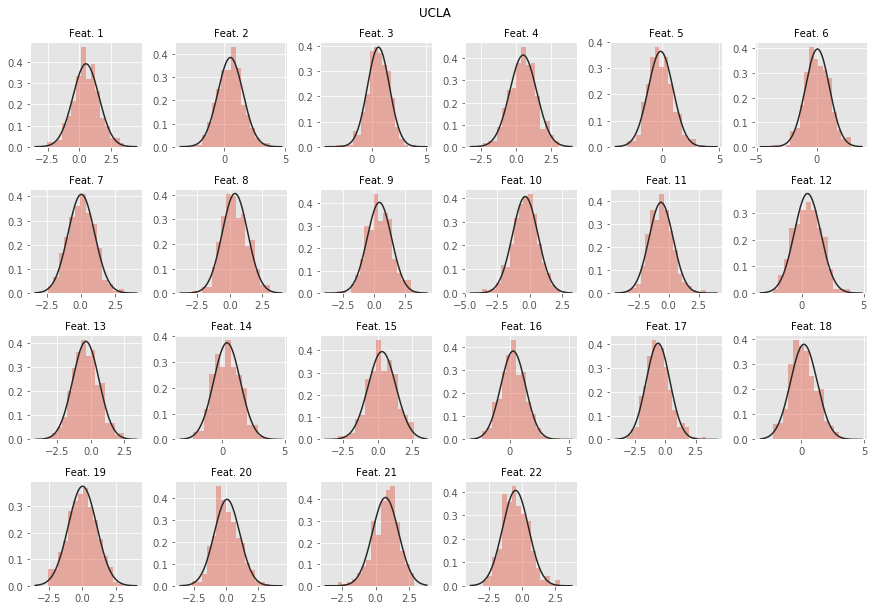

In [12]:
# Plot the t-value histograms for each of the 22 features

from scipy import stats

# Set up the plot
fig, axes = plt.subplots(nrows=4,ncols=6,figsize=(15,10))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
fig.suptitle(str(dataset), y=0.93)
    
for feature in range(1, feats+1):

    featureName = featList[feature-1]

    featSlice = af.getFeatSlice(ROIs,subjects,tsData,featureName,indices2KeepMat)

    # Assign the data to variables
    DataSlice = featSlice

    tpValDf, tpValDf_sorted, sigPValInds = af.getTPVals(targetCol, DataSlice)

    # iterate through all axes
    if (feature % 6) == 0:
        row = feature // 6 - 1
        col = 6 - 1
    else:
        row = (feature // 6)
        col = feature % 6 - 1
    
    # Create current subplot location
    ax_curr = axes[row, col]
    
    feat_tvals = tpValDf['t-value']
    
    # Plot the histograms
    sns.distplot(feat_tvals, kde=False, fit=stats.norm, ax=ax_curr)
    ax_curr.set_title('Feat. ' + str(feature), fontsize=10)
    ax_curr.set_xlabel('')
    
fig.delaxes(axes[3][5])
fig.delaxes(axes[3][4])
    
plt.show()

In [13]:
# Show me the PCA figure

# af.showMePCAFig(DataSlice, targetCol)

In [14]:
# Show me the top five features / ROIs as violin plots in the ROI / feature being analysed

# af.showMeViolinPlts(targetCol, sigPValInds, DataSlice, 1, ROI) # When looking at ROISlices

# af.showMeViolinPlts(targetCol, sigPValInds, DataSlice, 0, feature) # When looking at featSlices

In [15]:
# Initialise a few boolean variables which decide what the outputs are

dispFigs = True
regAccOnly = False
featAccOnly = False
    
# af.showMeROIAccPlot(ROIs, tsData, indices2KeepMat, targetCol, dispFigs)

In [16]:
# Define a function, showMeFeatAccPlot
    
# af.showMeFeatAccPlot(element, subPath, PyFeatList, indices2KeepMat, targetCol, dispFigs)

In [17]:
# Region by Region Analysis

# af.Reg_by_Reg_Anal(ROI, tsData, targetCol, ROIs, indices2KeepMat, regAccOnly, dispFigs)

In [18]:
# Feature by Feature Analysis

# af.Feat_by_Feat_Anal(feature, featureName, element, subPath, PyFeatList, indices2KeepMat, targetCol, featAccOnly, dispFigs)

In [19]:
# x = unknown
# x = x.tolist()
# plt.hist(x,100)
# plt.show()

In [20]:
def giveMeSortedFeats(element, subPath, PyFeatList, indices2KeepMat, targetCol):
    ''' This function returns the sorted feature accuracies for the given dataset '''

    tsData, ROIs, subjects, feats, featList = af.addIndices(element, subPath, PyFeatList)

    # Initialise a few variables
    featNo = np.zeros([feats])
    feat_acc = np.zeros([feats])
    featErr = np.zeros([feats])

    for n in range(1, feats+1):

        # For each of the 1 to 22 features, show me how good all of the ROIs are at predicting
        # whether the subject has SCZ or not
        tsDataSlice = af.getFeatSlice(ROIs, subjects, tsData, featList[n-1], indices2KeepMat)
        tsDataSlice_zscored = tsDataSlice.apply(zscore)

        # Assign the data to variables
        X = tsDataSlice_zscored
        y = np.ravel(targetCol)

        avgScore = af.get10FoldCVScore(X,y).mean()
        avgSTD = af.get10FoldCVScore(X,y).std()
        featNo[n-1] = n
        feat_acc[n-1] = avgScore
        featErr[n-1] = avgSTD

    df = pd.DataFrame({'Feature':featNo,'% Accuracy':feat_acc,'Feat Error':featErr})
    df['Feature'] = df.Feature.astype(int)

    df_sorted = df.sort_values(by='% Accuracy',ascending=False)
#     df_sorted = df_sorted.set_index('Feature')
    return df_sorted

df_sorted = giveMeSortedFeats(element, subPath, PyFeatList, indices2KeepMat, targetCol)

outFileName = 'sortedFeats_' + str(dataset) + '.txt'

# df_sorted.to_csv(outFileName, index=False)

    UCLA Feature  UCLA Feat Acc (%)  UCLA Feat Error (%)
3              1             56.628            11.628645
13             2             52.058            11.969631
1              3             57.294            10.256191
0              4             58.455            10.575818
2              5             56.691            11.305549
15             6             51.346             9.786335
21             7             41.565             7.459397
17             8             49.930            11.671320
16             9             50.070            10.938685
20            10             46.386             9.424997
6             11             55.495             9.634925
14            12             51.428             8.770512
18            13             49.770            10.882897
7             14             54.847             9.835078
11            15             53.801            14.331299
10            16             54.212             9.445022
4             17             55

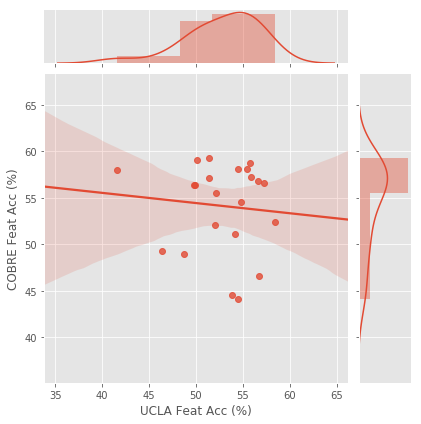

In [21]:
filePath = '/Users/AV/Desktop/FeatureMatrixData/sortedFeats_UCLA.txt'
df1 = pd.read_csv(filePath);
df1 = df1.sort_values(by='Feature')
df1.columns = ['UCLA Feature', 'UCLA Feat Acc (%)', 'UCLA Feat Error (%)']
uclaFeats = df1.iloc[:,1]
uclaSDs = df1.iloc[:,2]

print(df1)
print('')

# uclaFeats.to_csv('UCLAFeats.txt', index=0)

filePath = '/Users/AV/Desktop/FeatureMatrixData/sortedFeats_COBRE.txt'
df2 = pd.read_csv(filePath);
df2 = df2.sort_values(by='Feature')
df2.columns = ['COBRE Feature', 'COBRE Feat Acc (%)', 'COBRE Feat Error (%)']
cobreFeats = df2.iloc[:,1]
cobreSDs = df2.iloc[:,2]

print(df2)

# cobreFeats.to_csv('COBREFeats.txt', index=0)

sns.jointplot(uclaFeats, cobreFeats, kind='reg')
plt.show()

In [36]:
# Store and combine p-values for both datasets

# Initialise pval_UCLA and pval_COBRE 1x22 array of zeros
pvals_UCLA = np.zeros(22)
pvals_COBRE = np.zeros(22)
pvals_combined = np.zeros(22)

filePath1 = '/Users/AV/Desktop/FeatureMatrixData/featBalancedAcc_UCLA_shuff.txt'
shuffData_UCLA = pd.read_csv(filePath1);

filePath2 = '/Users/AV/Desktop/FeatureMatrixData/featBalancedAcc_COBRE_shuff.txt'
shuffData_COBRE = pd.read_csv(filePath2);

for feature in range(1, feats+1):
    
    # Get the rows corresponding to each feature
    shuffFeatSlice_UCLA = shuffData_UCLA.iloc[((int(feature)-1)*1000):(int(feature)*1000),:]
    shuffFeatSlice_COBRE = shuffData_COBRE.iloc[((int(feature)-1)*1000):(int(feature)*1000),:]
    
    feat_acc_UCLA = shuffFeatSlice_UCLA.iloc[:,2]
    feat_acc_COBRE = shuffFeatSlice_COBRE.iloc[:,2]
    
    arr_UCLA = np.asarray(feat_acc_UCLA)
    arr_COBRE = np.asarray(feat_acc_COBRE)
    
    uclaFeats = np.asarray(uclaFeats)
    cobreFeats = np.asarray(cobreFeats)
    
    uclaSDs = np.asarray(uclaSDs)
    cobreSDs = np.asarray(cobreSDs)
    
    ''' What is the likelihood that a randomly calculated classification accuracy will beat
    the mean feature accuracy that has been calculated? '''
    
    # Z-score all of the iterative classification accuracies using the mean and SD of the current feature
    # Take the mean of the absolute value of the z-scores
    # Calculate the p-value using this 'average' z-score value
    # Do this for both datasets
    
    from scipy.stats import norm
    
    zscores1 = (arr_UCLA - uclaFeats[int(feature)-1])/uclaSDs[int(feature)-1]
    pval1 = norm.sf(abs(zscores1).mean())
    
    zscores2 = (arr_COBRE - cobreFeats[int(feature)-1])/cobreSDs[int(feature)-1]
    pval2 = norm.sf(abs(zscores2).mean())
    
    pvals_UCLA[int(feature)-1] = pval1
    pvals_COBRE[int(feature)-1] = pval2

    pvalues = [pval1, pval2]
    pvalues = np.asarray(pvalues)

    pvals_combined[int(feature)-1] = "%.3f" % stats.combine_pvalues(pvalues, method='fisher')[1]
    
# print('Combined p-values =', pvals_combined)

df = pd.DataFrame(data=pvals_combined, columns=['Combined P-Values'])
df.index.name = 'Feature'
df.index += 1
print(df)

# df.to_csv('combined_pvals_22features.txt', index=False)

         Combined P-Values
Feature                   
1                    0.272
2                    0.416
3                    0.262
4                    0.245
5                    0.306
6                    0.357
7                    0.170
8                    0.358
9                    0.353
10                   0.343
11                   0.239
12                   0.244
13                   0.373
14                   0.342
15                   0.392
16                   0.357
17                   0.270
18                   0.367
19                   0.385
20                   0.267
21                   0.248
22                   0.245
